In [2]:
# -*- coding: utf-8 -*-

import sys,os
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import linalg
from numpy import dot

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import grad
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch.nn.modules import Linear
from torch.autograd.functional import jacobian,hessian,vjp,vhp,hvp

import random
import math

filePath = '../'
file_list = ['GSM1599494_ES_d0_main.csv', 'GSM1599497_ES_d2_LIFminus.csv', 'GSM1599498_ES_d4_LIFminus.csv', 'GSM1599499_ES_d7_LIFminus.csv']

table_list = []
for filein in file_list:
    table_list.append(pd.read_csv(filePath+filein, header=None))

matrix_list = []
gene_names = table_list[0].values[:,0]
for table in table_list:
    matrix_list.append(table.values[:,1:].astype('float32'))

cell_counts = [matrix.shape[1] for matrix in matrix_list]

def normalize_run(mat):
    rpm = np.sum(mat,0)/1e6
    detect_pr = np.sum(mat==0,0)/float(mat.shape[0])
    return np.log(mat*(np.median(detect_pr)/detect_pr)*1.0/rpm + 1.0)

norm_mat = [normalize_run(matrix) for matrix in matrix_list]

qt_mat = [np.percentile(norm_in,q=np.linspace(0,100,50),axis=1) for norm_in in norm_mat] 
wdiv=np.sum((qt_mat[0]-qt_mat[3])**2,0)
w_order = np.argsort(-wdiv)

wsub = w_order[0:100]


def nmf(X, latent_features, max_iter=100, error_limit=1e-6, fit_error_limit=1e-6, print_iter=200):
    """
    Decompose X to A*Y
    """
    eps = 1e-5
    print('Starting NMF decomposition with {} latent features and {} iterations.'.format(latent_features, max_iter))
    #X = X.toarray()   I am passing in a scipy sparse matrix

    # mask
    mask = np.sign(X)

    # initial matrices. A is random [0,1] and Y is A\X.
    rows, columns = X.shape
    A = np.random.rand(rows, latent_features)
    A = np.maximum(A, eps)

    Y = linalg.lstsq(A, X)[0]
    Y = np.maximum(Y, eps)

    masked_X = mask * X
    X_est_prev = dot(A, Y)
    for i in range(1, max_iter + 1):
        # ===== updates =====
        # Matlab: A=A.*(((W.*X)*Y')./((W.*(A*Y))*Y'));
        top = dot(masked_X, Y.T)
        bottom = (dot((mask * dot(A, Y)), Y.T)) + eps
        A *= top / bottom

        A = np.maximum(A, eps)
        # print 'A',  np.round(A, 2)

        # Matlab: Y=Y.*((A'*(W.*X))./(A'*(W.*(A*Y))));
        top = dot(A.T, masked_X)
        bottom = dot(A.T, mask * dot(A, Y)) + eps
        Y *= top / bottom
        Y = np.maximum(Y, eps)
        # print 'Y', np.round(Y, 2)


        # ==== evaluation ====
        if i % print_iter == 0 or i == 1 or i == max_iter:
            print('Iteration {}:'.format(i),)
            X_est = dot(A, Y)
            err = mask * (X_est_prev - X_est)
            fit_residual = np.sqrt(np.sum(err ** 2))
            X_est_prev = X_est

            curRes = linalg.norm(mask * (X - X_est), ord='fro')
            print('fit residual', np.round(fit_residual, 4),)
            print('total residual', np.round(curRes, 4))
            if curRes < error_limit or fit_residual < fit_error_limit:
                break
    return A, Y, dot(A,Y)

np.random.seed(0)
norm_imputed = [nmf(normin[wsub,:], latent_features = len(wsub)*4, max_iter=500)[2] for normin in norm_mat]

norm_adj = np.mean(norm_imputed[3],1)[:,np.newaxis]
subvec = np.array([0,1,2,3,4,5,6,7,8,9])

gnvec = gene_names[w_order[subvec]]

cov_mat = np.cov(norm_imputed[3][subvec,:])
whiten = np.diag(np.diag(cov_mat)**(-0.5))
unwhiten = np.diag(np.diag(cov_mat)**(0.5))

norm_imputed2 = [np.dot(whiten,(normin - norm_adj)[subvec,:]) for normin in norm_imputed]

Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 4000.1233
total residual 138.7959
Iteration 200:
fit residual 123.6643
total residual 31.8464
Iteration 400:
fit residual 21.7894
total residual 12.6115
Iteration 500:
fit residual 4.3442
total residual 8.6686
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 2257.8358
total residual 58.2265
Iteration 200:
fit residual 56.8198
total residual 4.0447
Iteration 400:
fit residual 3.4777
total residual 0.6841
Iteration 500:
fit residual 0.3744
total residual 0.3185
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 2925.3664
total residual 80.2657
Iteration 200:
fit residual 78.1148
total residual 6.1559
Iteration 400:
fit residual 5.1661
total residual 1.1917
Iteration 500:
fit residual 0.6183
total residual 0.5917
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
f

In [3]:
def setup_seed(seed):
     torch.cuda.manual_seed(seed)
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.benchmark=False
     torch.backends.cudnn.deterministic = True
setup_seed(40)

class MLP(nn.Module):

    def __init__(self, dim_in, dim_out, dim_hidden=64, num_hidden=0, activation=nn.Tanh()):
        super(MLP, self).__init__()

        if num_hidden == 0:
            self.linears = nn.ModuleList([nn.Linear(dim_in, dim_out)])
        elif num_hidden >= 1:
            self.linears = nn.ModuleList() 
            self.linears.append(nn.Linear(dim_in, dim_hidden))
            self.linears.extend([nn.Linear(dim_hidden, dim_hidden) for _ in range(num_hidden-1)])
            self.linears.append(nn.Linear(dim_hidden, dim_out))
        else:
            raise Exception('number of hidden layers must be positive')

        for m in self.linears:
            nn.init.xavier_normal_(m.weight)
            nn.init.uniform_(m.bias,a=-0.1,b=0.1)
 
        self.activation = activation 

    def forward(self, x):
        for m in self.linears[:-1]:
            x = self.activation(m(x))

        return self.linears[-1](x)
    
class JumpEulerForwardCuda(nn.Module):
    def __init__(self,in_features,num_hidden,dim_hidden,step_size):
        super(JumpEulerForwardCuda,self).__init__()

        self.drift = MLP(in_features,in_features,dim_hidden,num_hidden)
        self.intensity = torch.tensor(100.0,device="cuda")
        self.mean = nn.Parameter(0.01*torch.ones(10))
        self.covHalf = nn.Parameter(0.08*torch.eye(10))
        self.diffusion = nn.Parameter(torch.ones(2,10))
        self.in_features = in_features
        self.jump = MLP(in_features,in_features,128,4)
        self.step_size = step_size

    def forward(self,z0,Nsim,steps):

        PopulationPath = torch.empty(size = (Nsim,steps+1,self.in_features),device="cuda")
        PopulationPath[:,0,:] = z0
        state = z0

        for i in range(1,steps+1):
            DP = D.poisson.Poisson(self.intensity*self.step_size)
            pois = DP.sample((Nsim,1)).cuda()
            state = state + self.drift(state)*self.step_size + math.sqrt(self.step_size)*torch.normal(0,1,size=(Nsim,2),device="cuda")@self.diffusion+\
                (pois*self.mean + pois**(0.5)*torch.normal(0,1,size=(Nsim,10),device="cuda")@self.covHalf)*self.jump(state)
            PopulationPath[:,i,:] = state
        return PopulationPath

In [4]:
train_data = norm_imputed2
in_features = subvec.shape[0]

train0 = torch.tensor(train_data[0],dtype=torch.float32,requires_grad = True,device="cuda").t()
train2 = torch.tensor(train_data[1],dtype=torch.float32,requires_grad = True,device="cuda").t()
train4 = torch.tensor(train_data[2],dtype=torch.float32,requires_grad = True,device="cuda").t()
train7 = torch.tensor(train_data[3],dtype=torch.float32,requires_grad = True,device="cuda").t()


n_sims = train0.shape[0]
n_steps = [10,35]
in_features = train0.shape[1]
step_size = 0.05


netG = JumpEulerForwardCuda(10,4,128,step_size).cuda()
netD1 = MLP(10,1,dim_hidden=128,num_hidden=4).cuda()
netD2 = MLP(10,1,dim_hidden=128,num_hidden=4).cuda()

In [5]:
setup_seed(100)

path = netG(train0,train0.shape[0],20)
G2 = path[:,10,:].detach().cpu().numpy()
G4 = path[:,20,:].detach().cpu().numpy()
T0 = train0.detach().cpu().numpy()
T2 = train2.detach().cpu().numpy()
T4 = train4.detach().cpu().numpy()

In [6]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})

print(gnvec)

['Krt8' 'Krt18' 'Tdh' 'Tagln' 'Mt1' 'Dppa5a' 'Mt2' 'Gsn' 'Lgals1' 'Pou5f1']


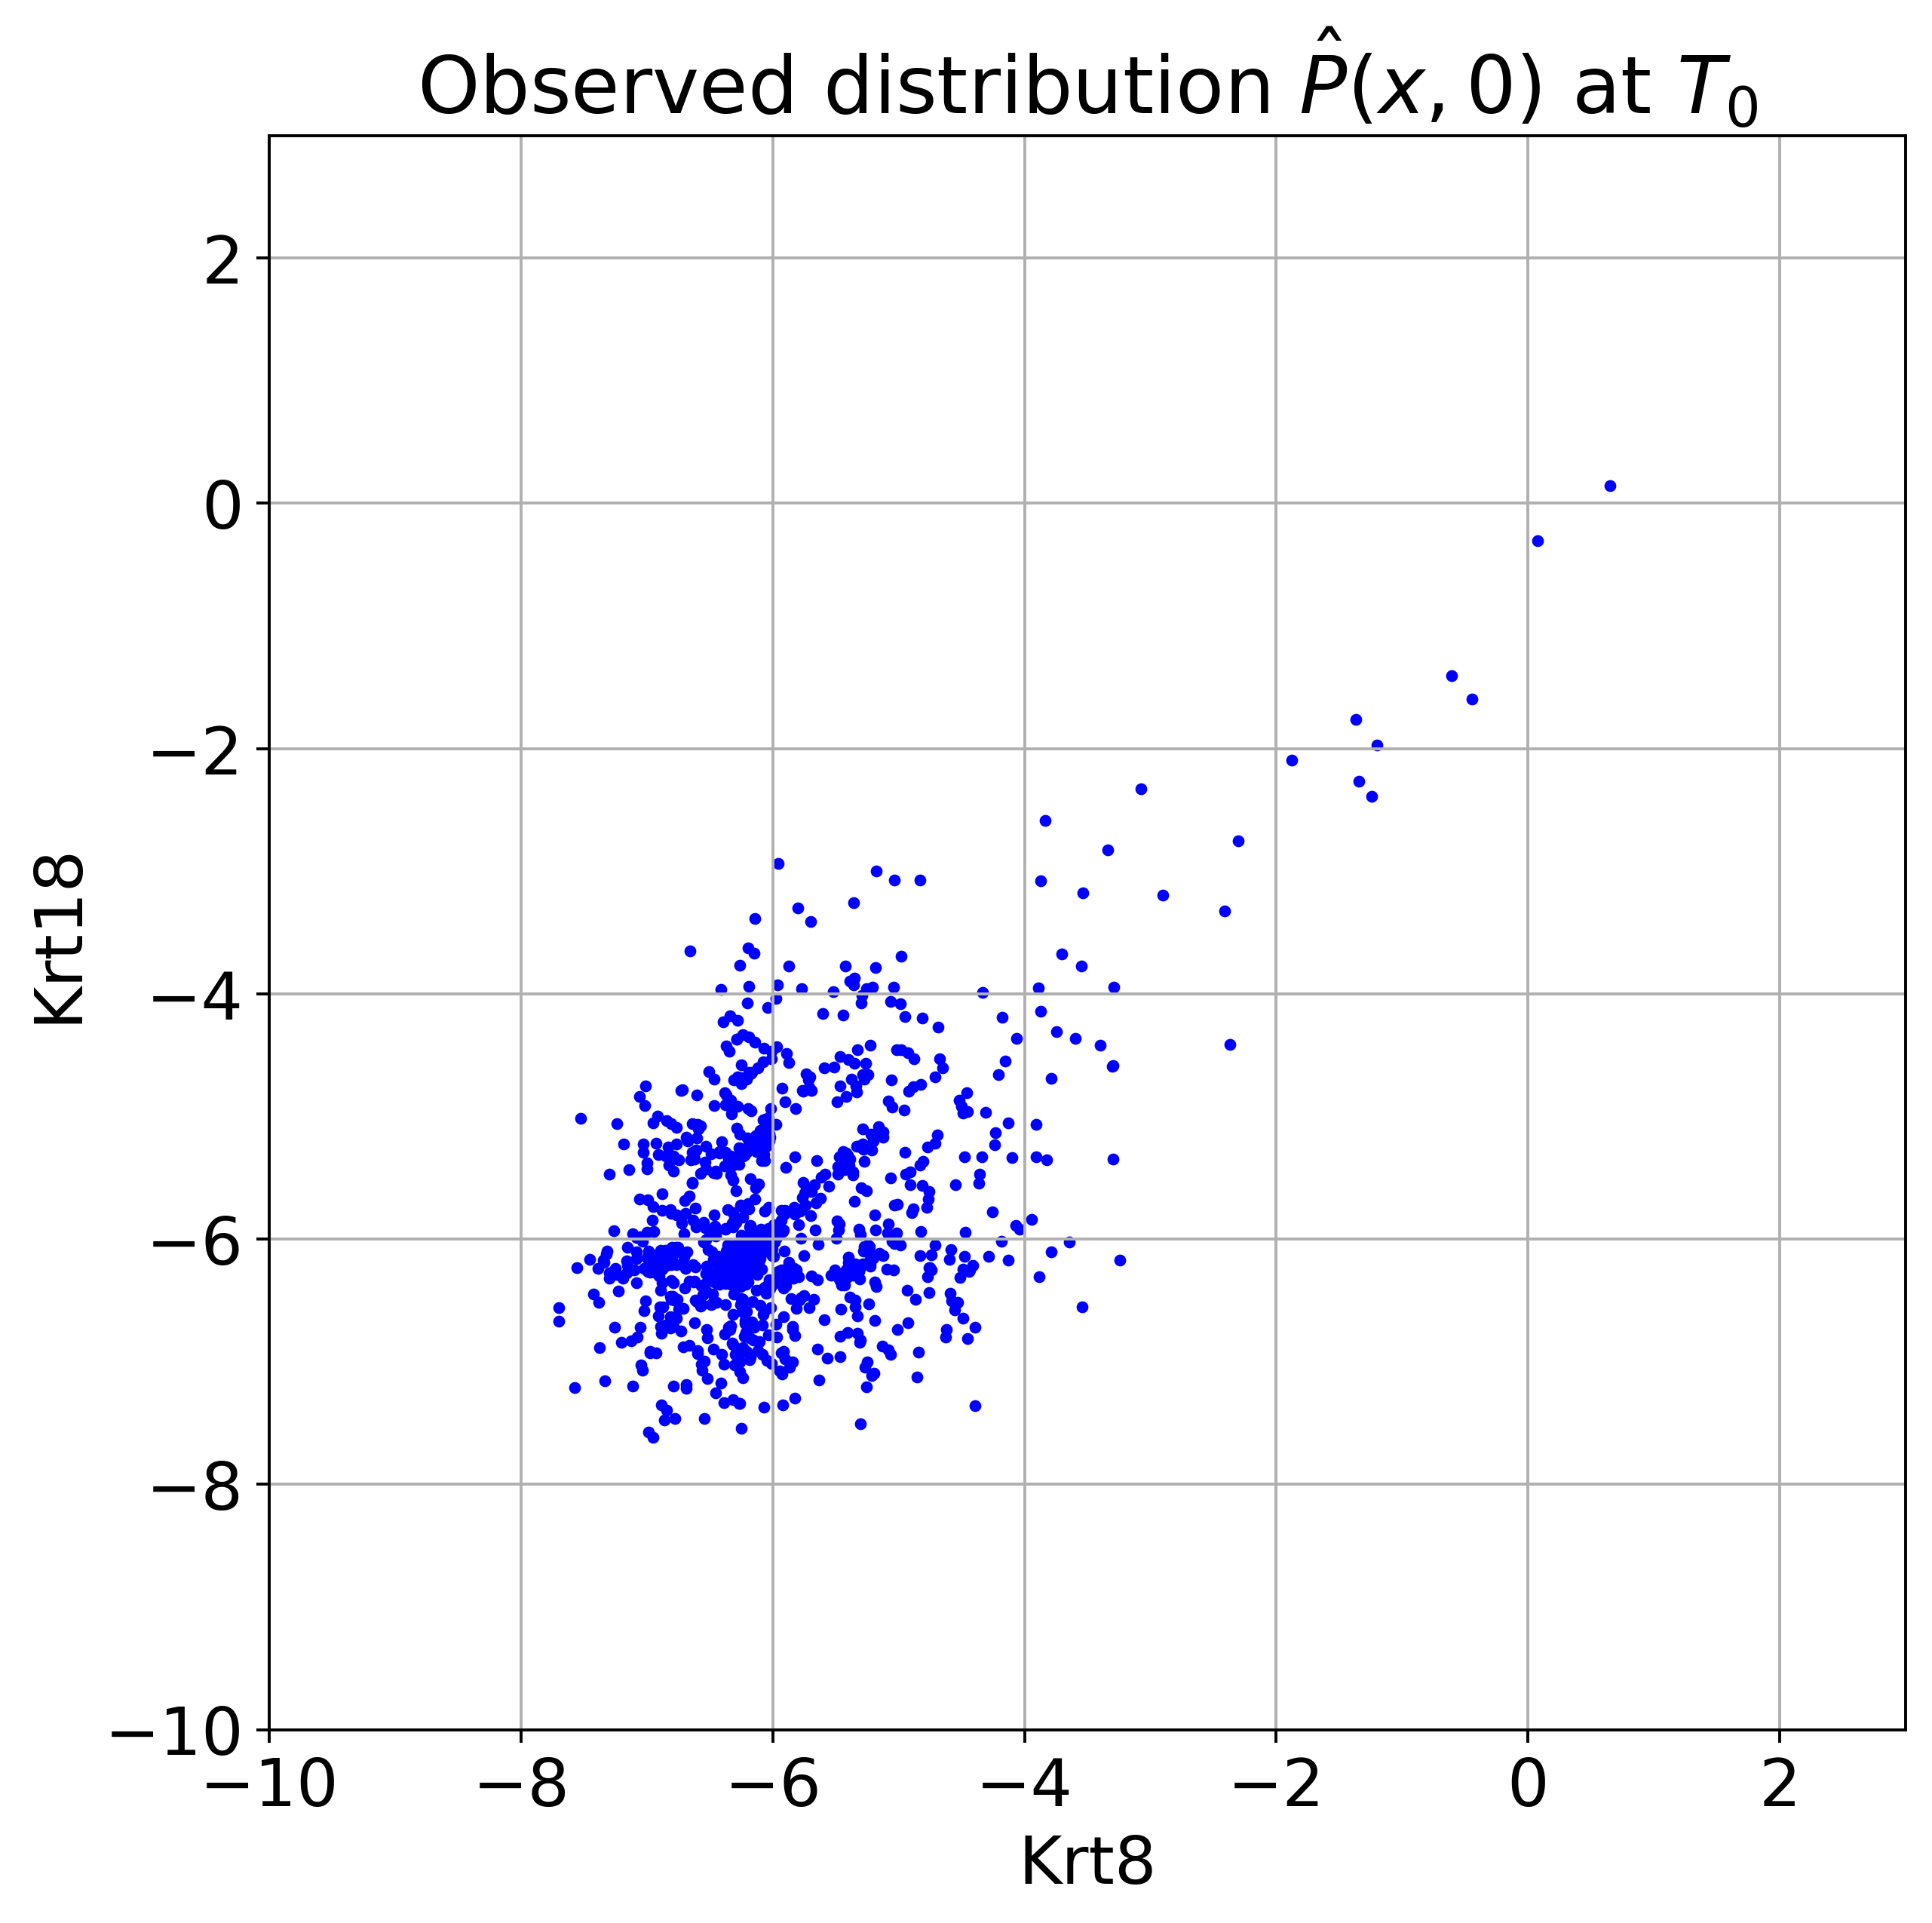

In [7]:
plt.figure(figsize=(8,8),dpi=350)
plt.xlim((-10,3))
plt.ylim((-10,3))
plt.title("Observed distribution $\hat{P}(x,0)$ at $T_0$")
plt.scatter(T0[:,0],T0[:,1],s=5,color="blue")
plt.xlabel("Krt8")
plt.ylabel("Krt18")
plt.grid()
plt.savefig('s1.eps',format='eps')

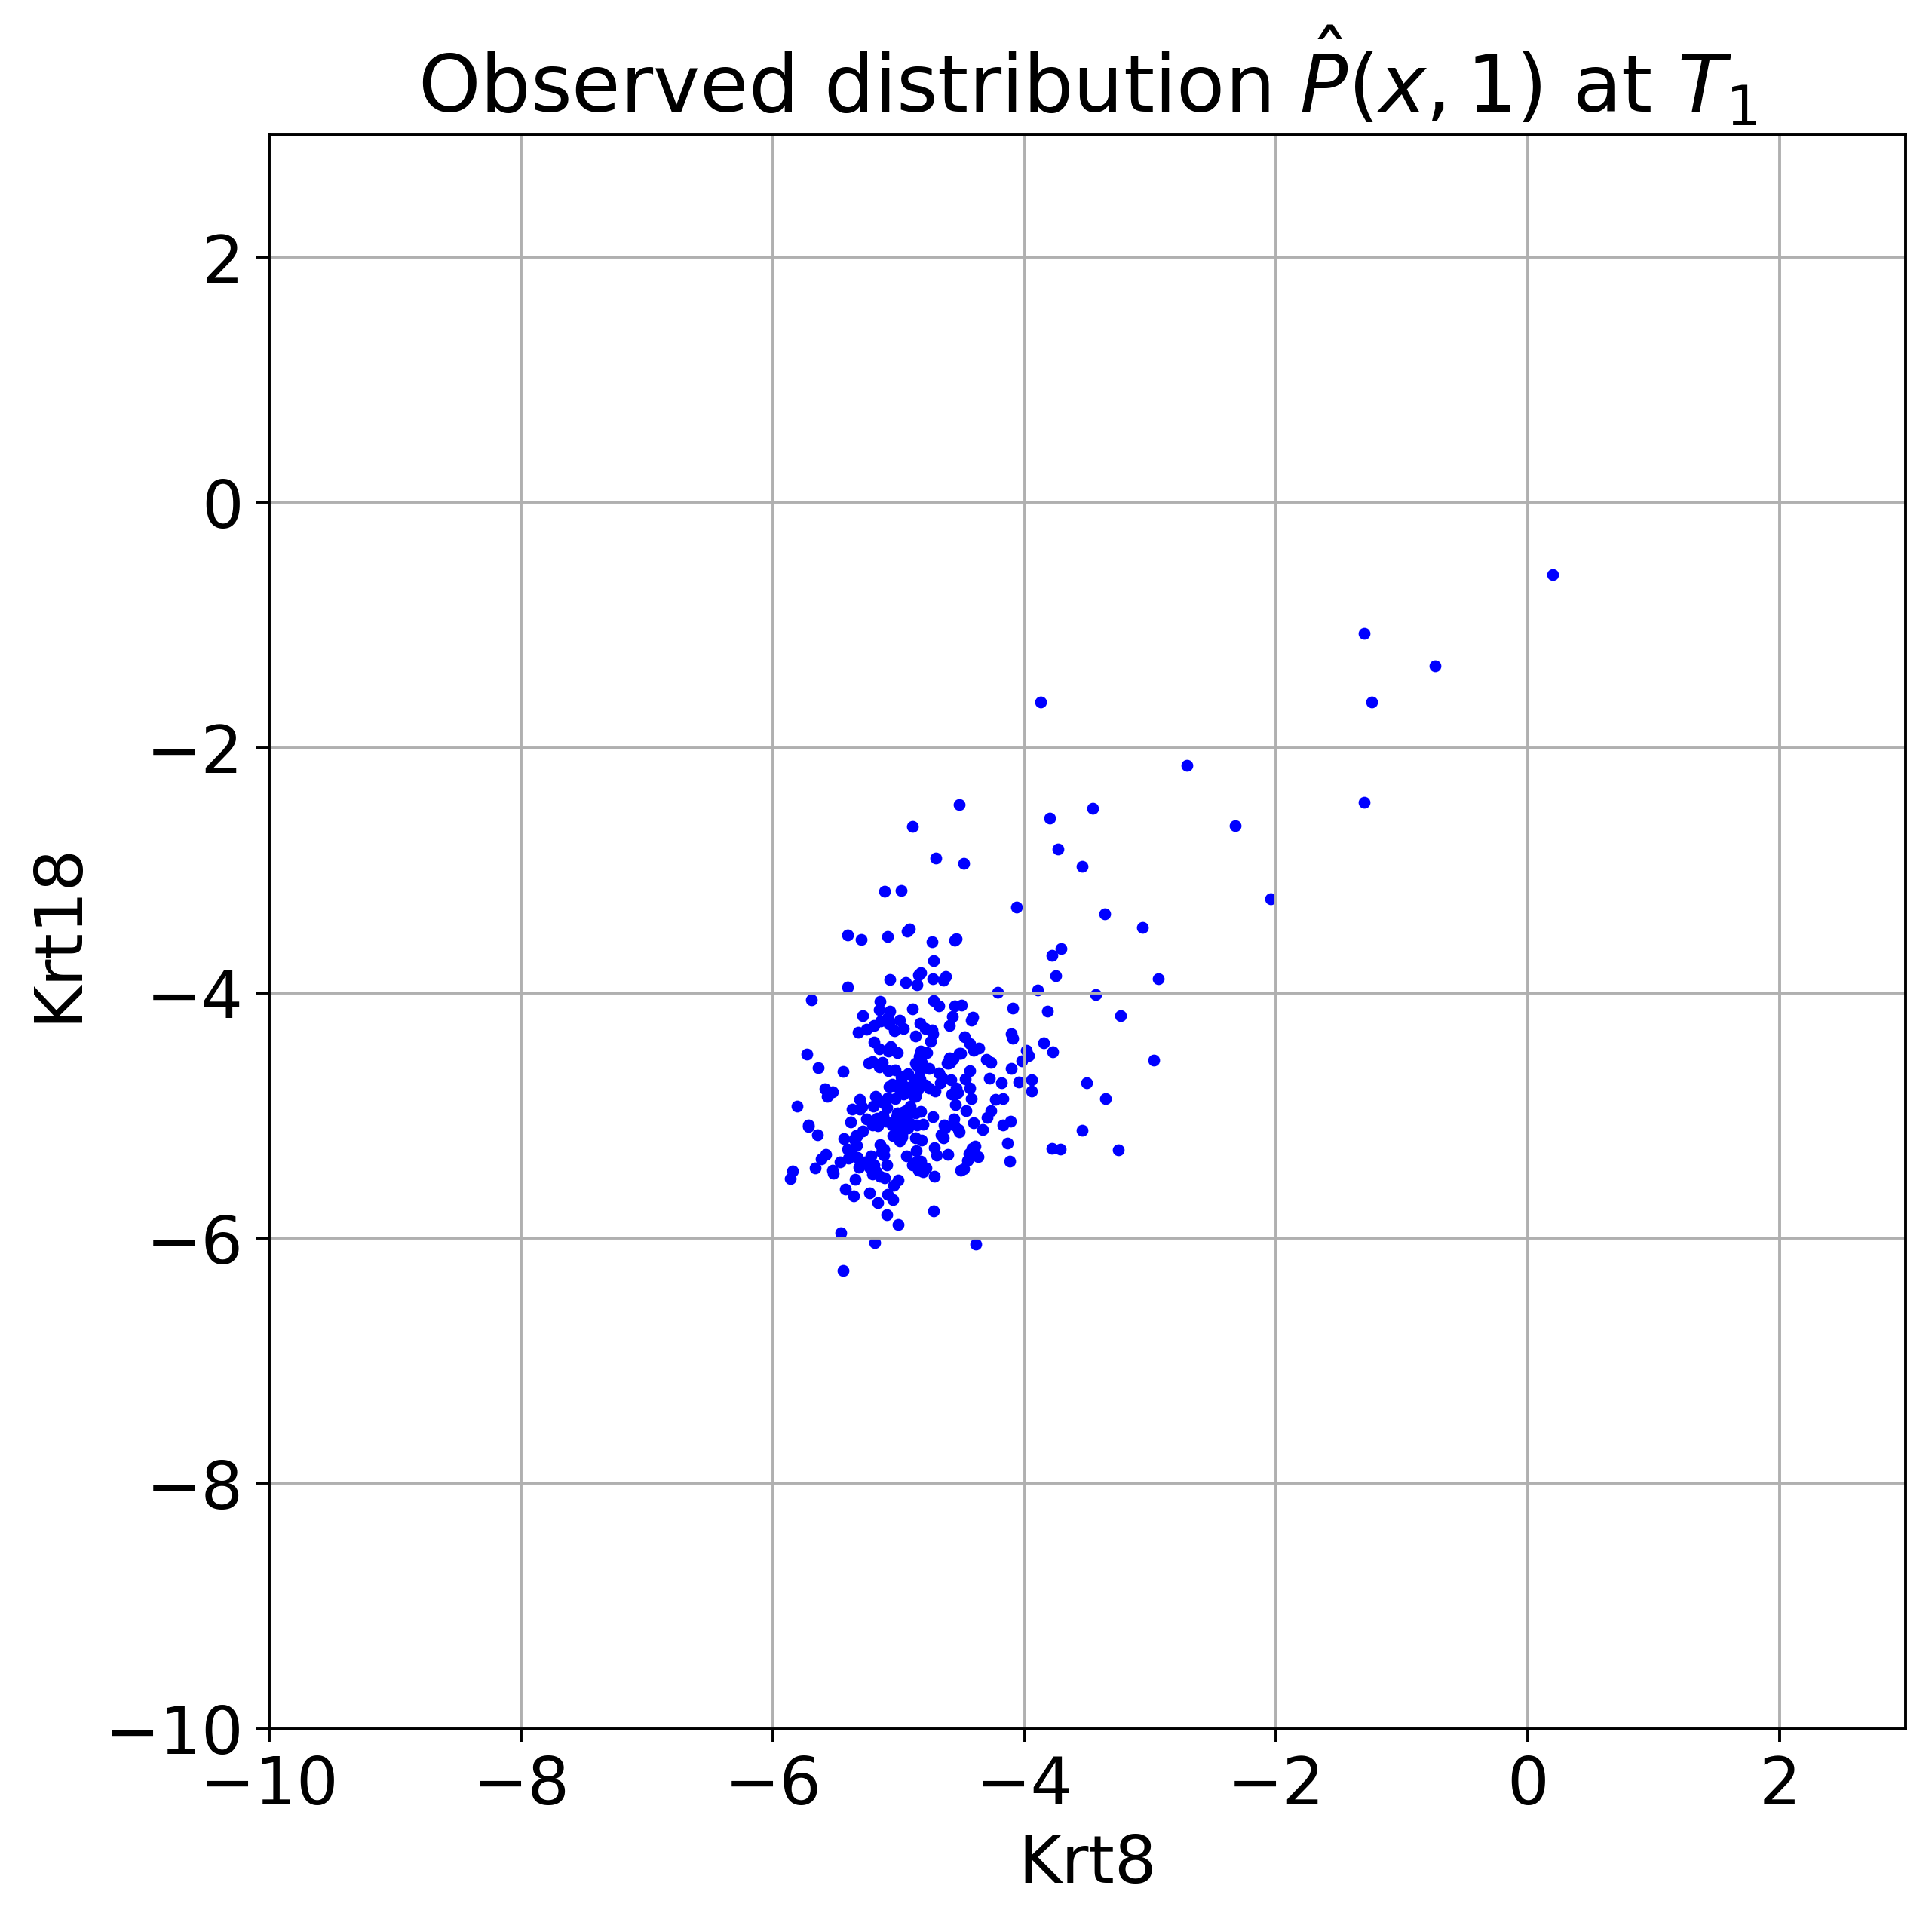

In [8]:
plt.figure(figsize=(8,8),dpi=350)
plt.xlim((-10,3))
plt.ylim((-10,3))
plt.title("Observed distribution $\hat{P}(x,1)$ at $T_1$")
plt.scatter(T2[:,0],T2[:,1],s=5,color="blue")
plt.xlabel("Krt8")
plt.ylabel("Krt18")
plt.grid()
plt.savefig('s2.eps',format='eps')

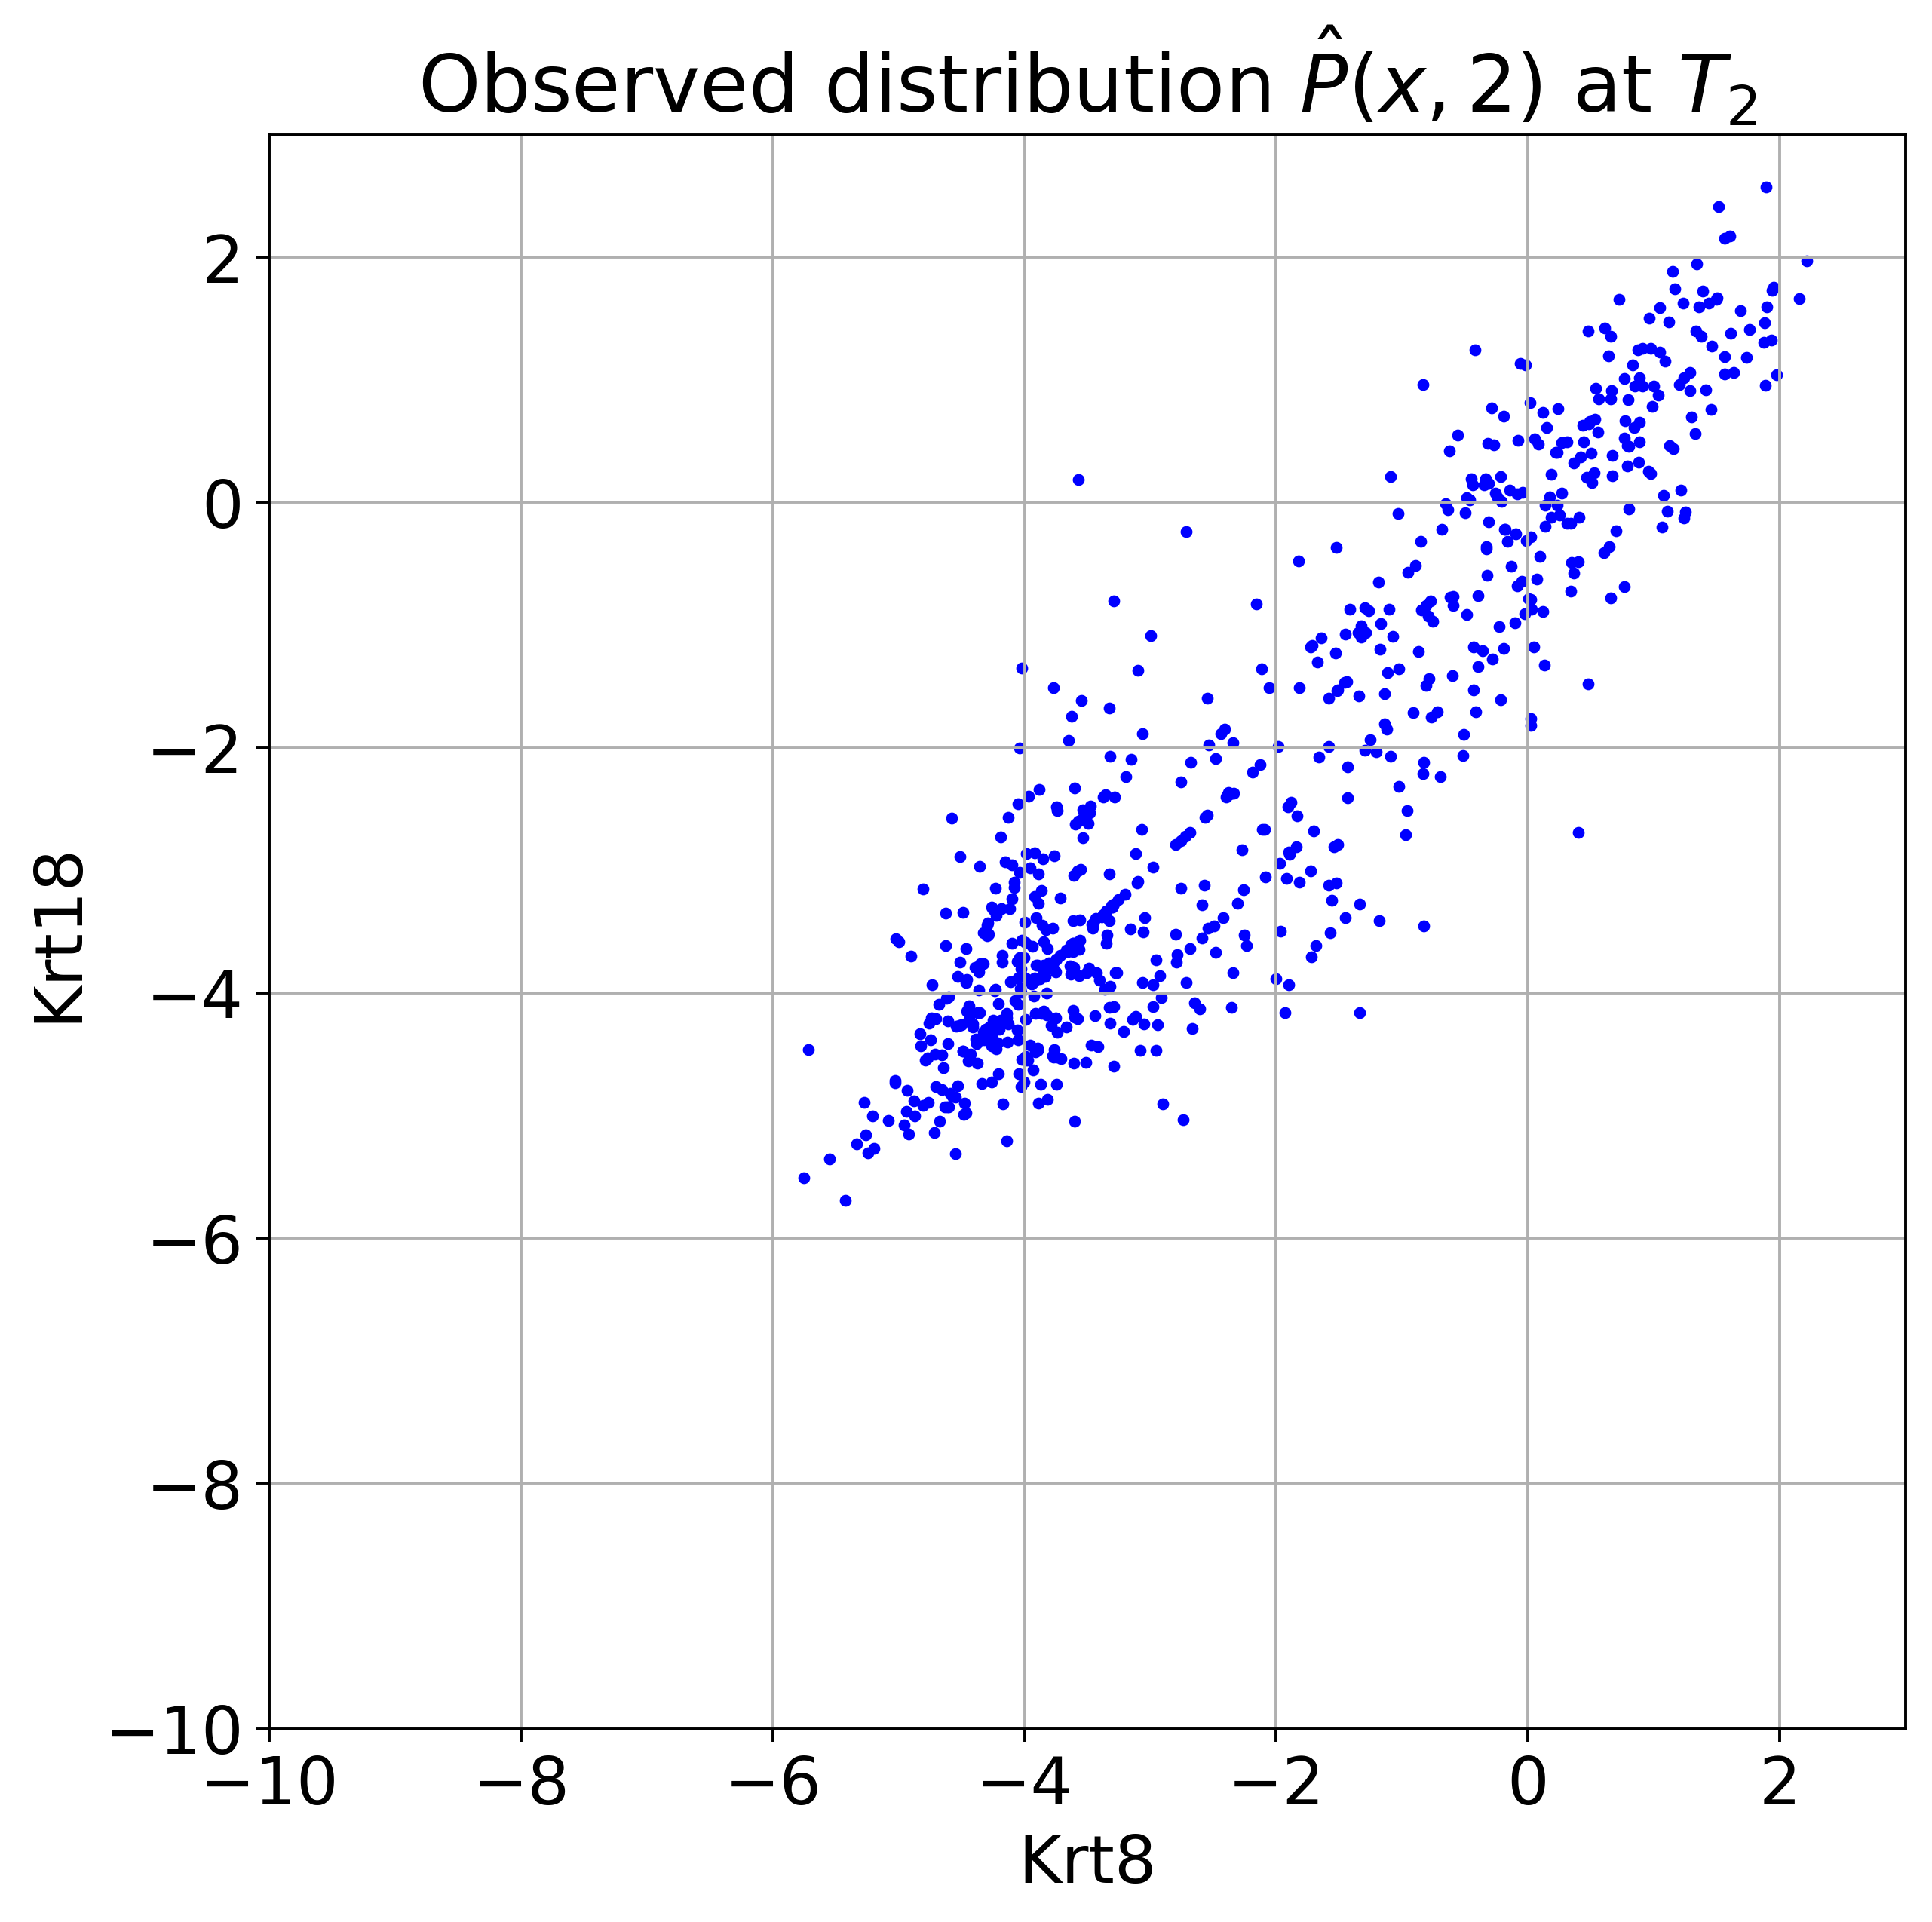

In [9]:
plt.figure(figsize=(8,8),dpi=350)
plt.xlim((-10,3))
plt.ylim((-10,3))
plt.title("Observed distribution $\hat{P}(x,2)$ at $T_2$")
plt.scatter(T4[:,0],T4[:,1],s=5,color="blue")
plt.xlabel("Krt8")
plt.ylabel("Krt18")
plt.grid()
plt.savefig('s3.eps',format='eps')

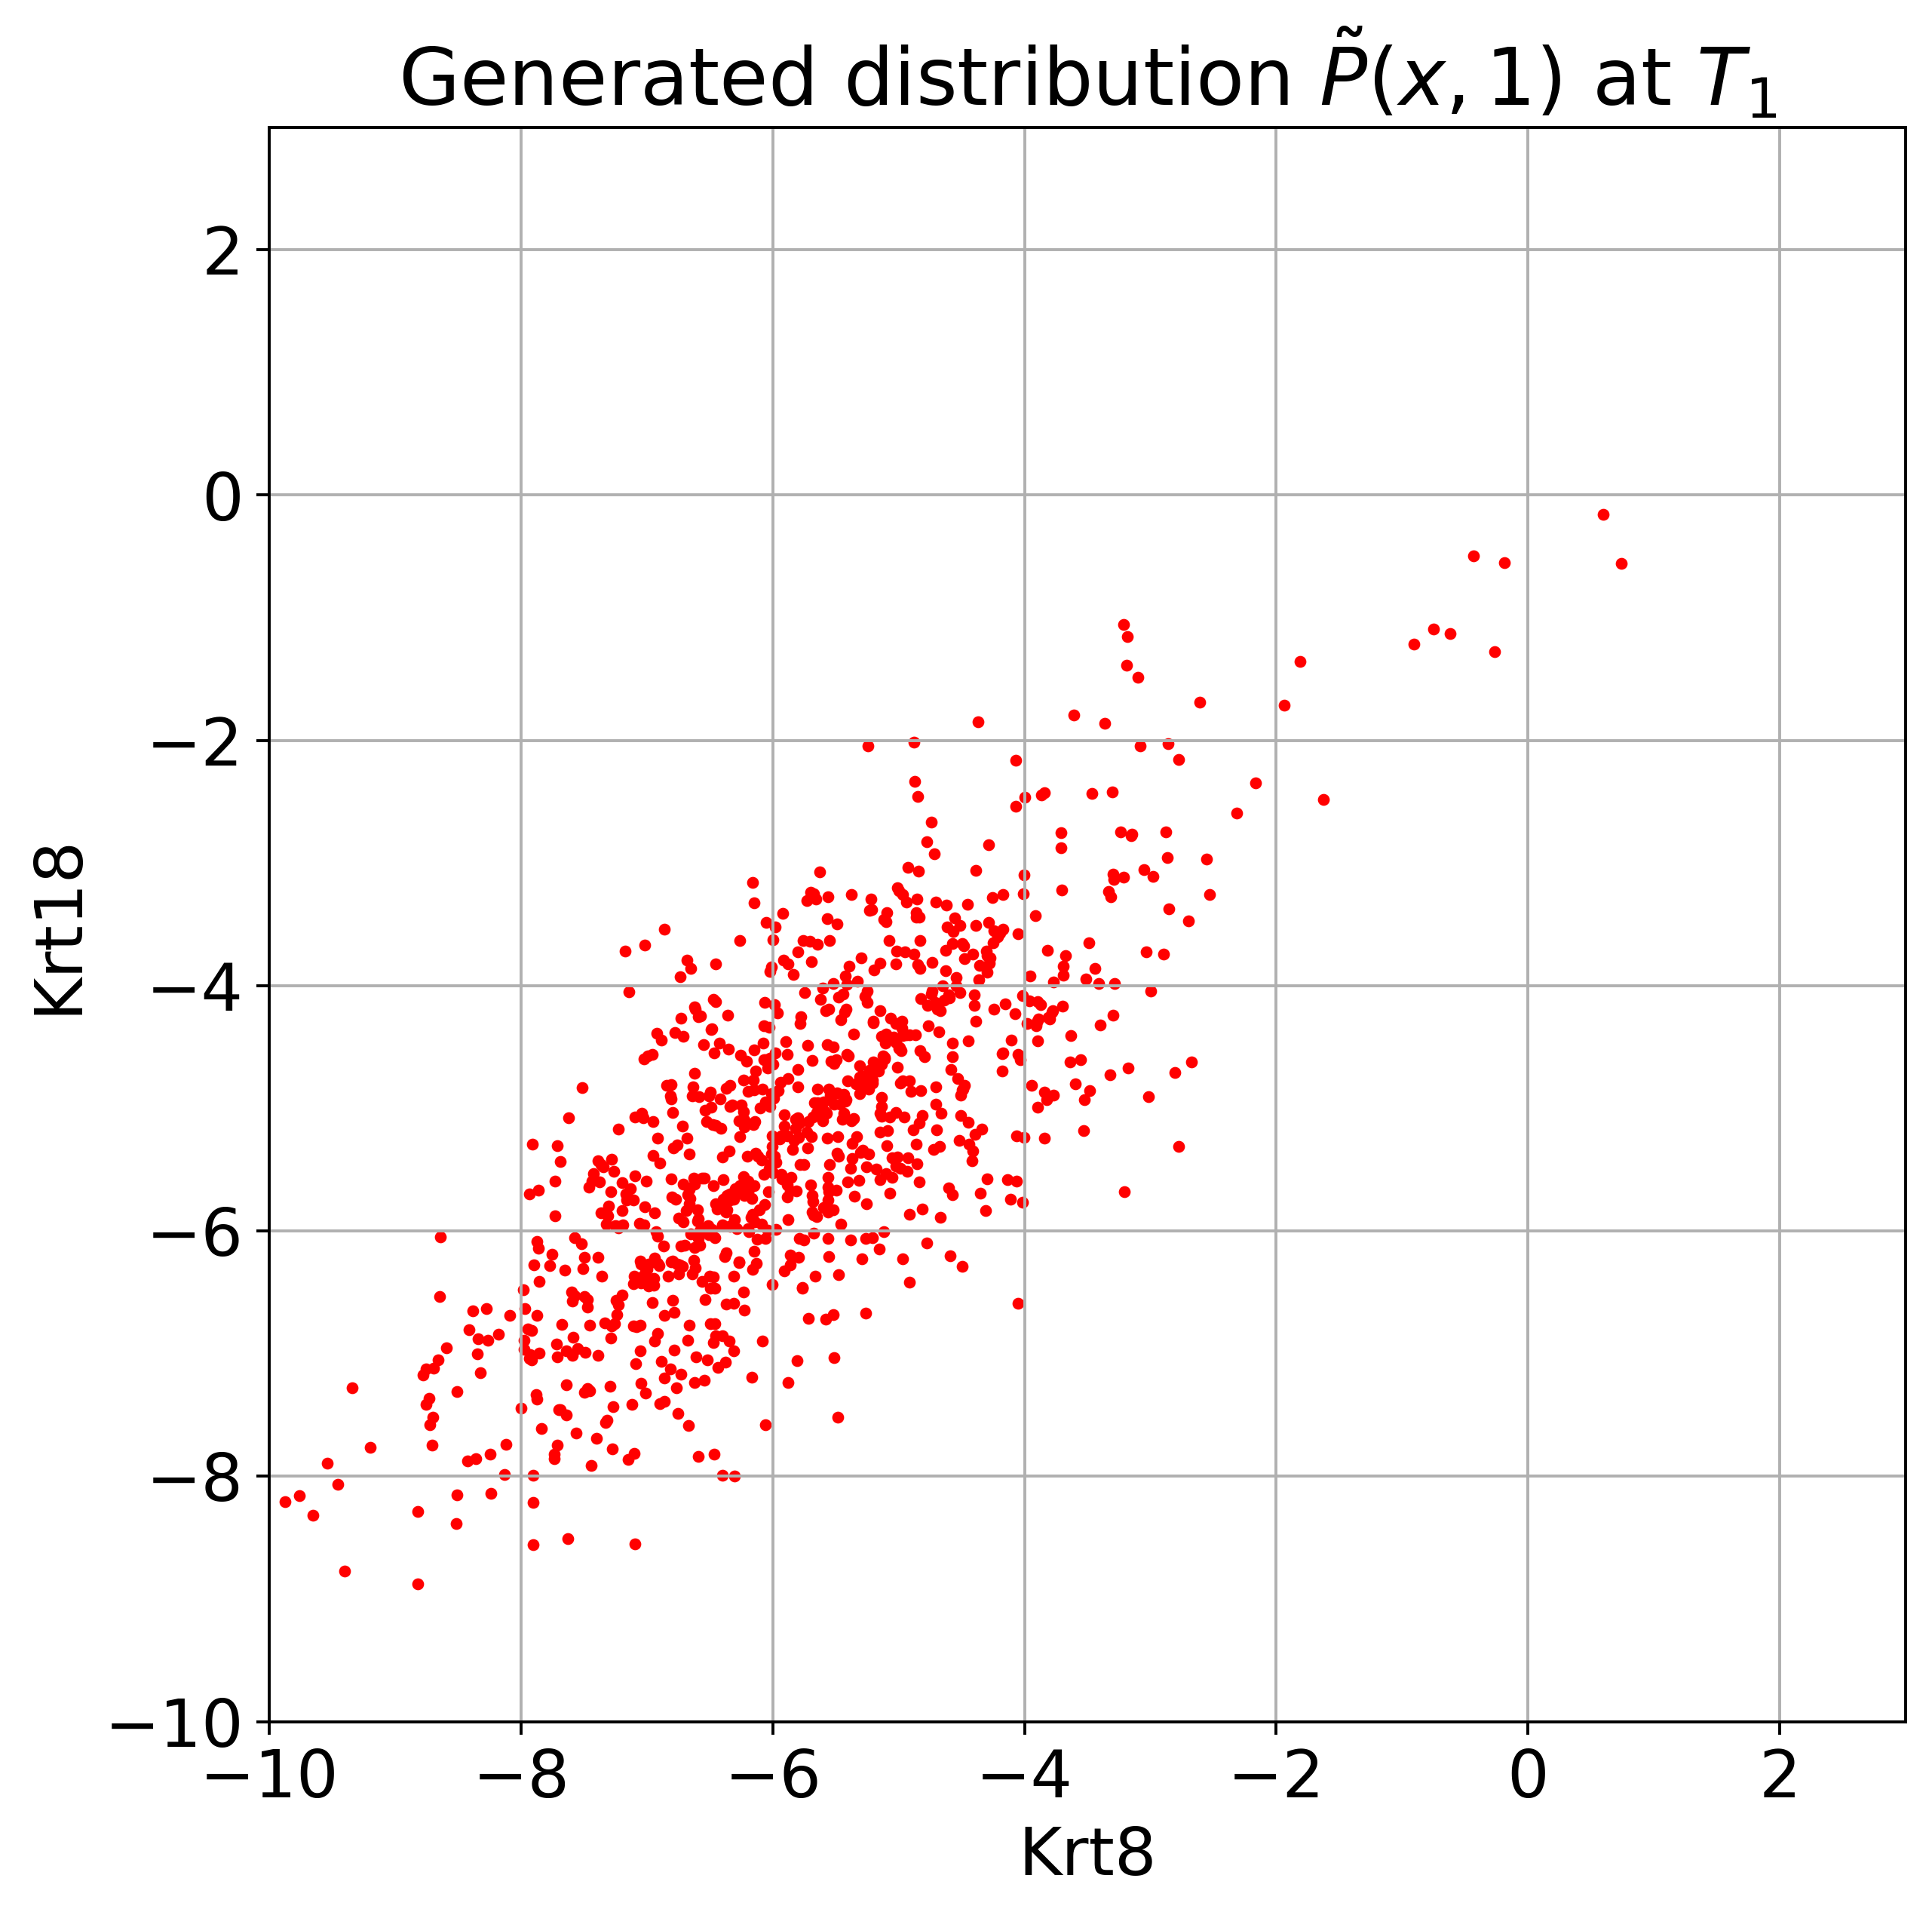

In [10]:
plt.figure(figsize=(8,8),dpi=350)
plt.xlim((-10,3))
plt.ylim((-10,3))
plt.title(r"Generated distribution $\tilde{P}(x,1)$ at $T_1$")
plt.scatter(G2[:,0],G2[:,1],s=5,color="red")
plt.xlabel("Krt8")
plt.ylabel("Krt18")
plt.grid()
plt.savefig('g1.eps',format='eps')

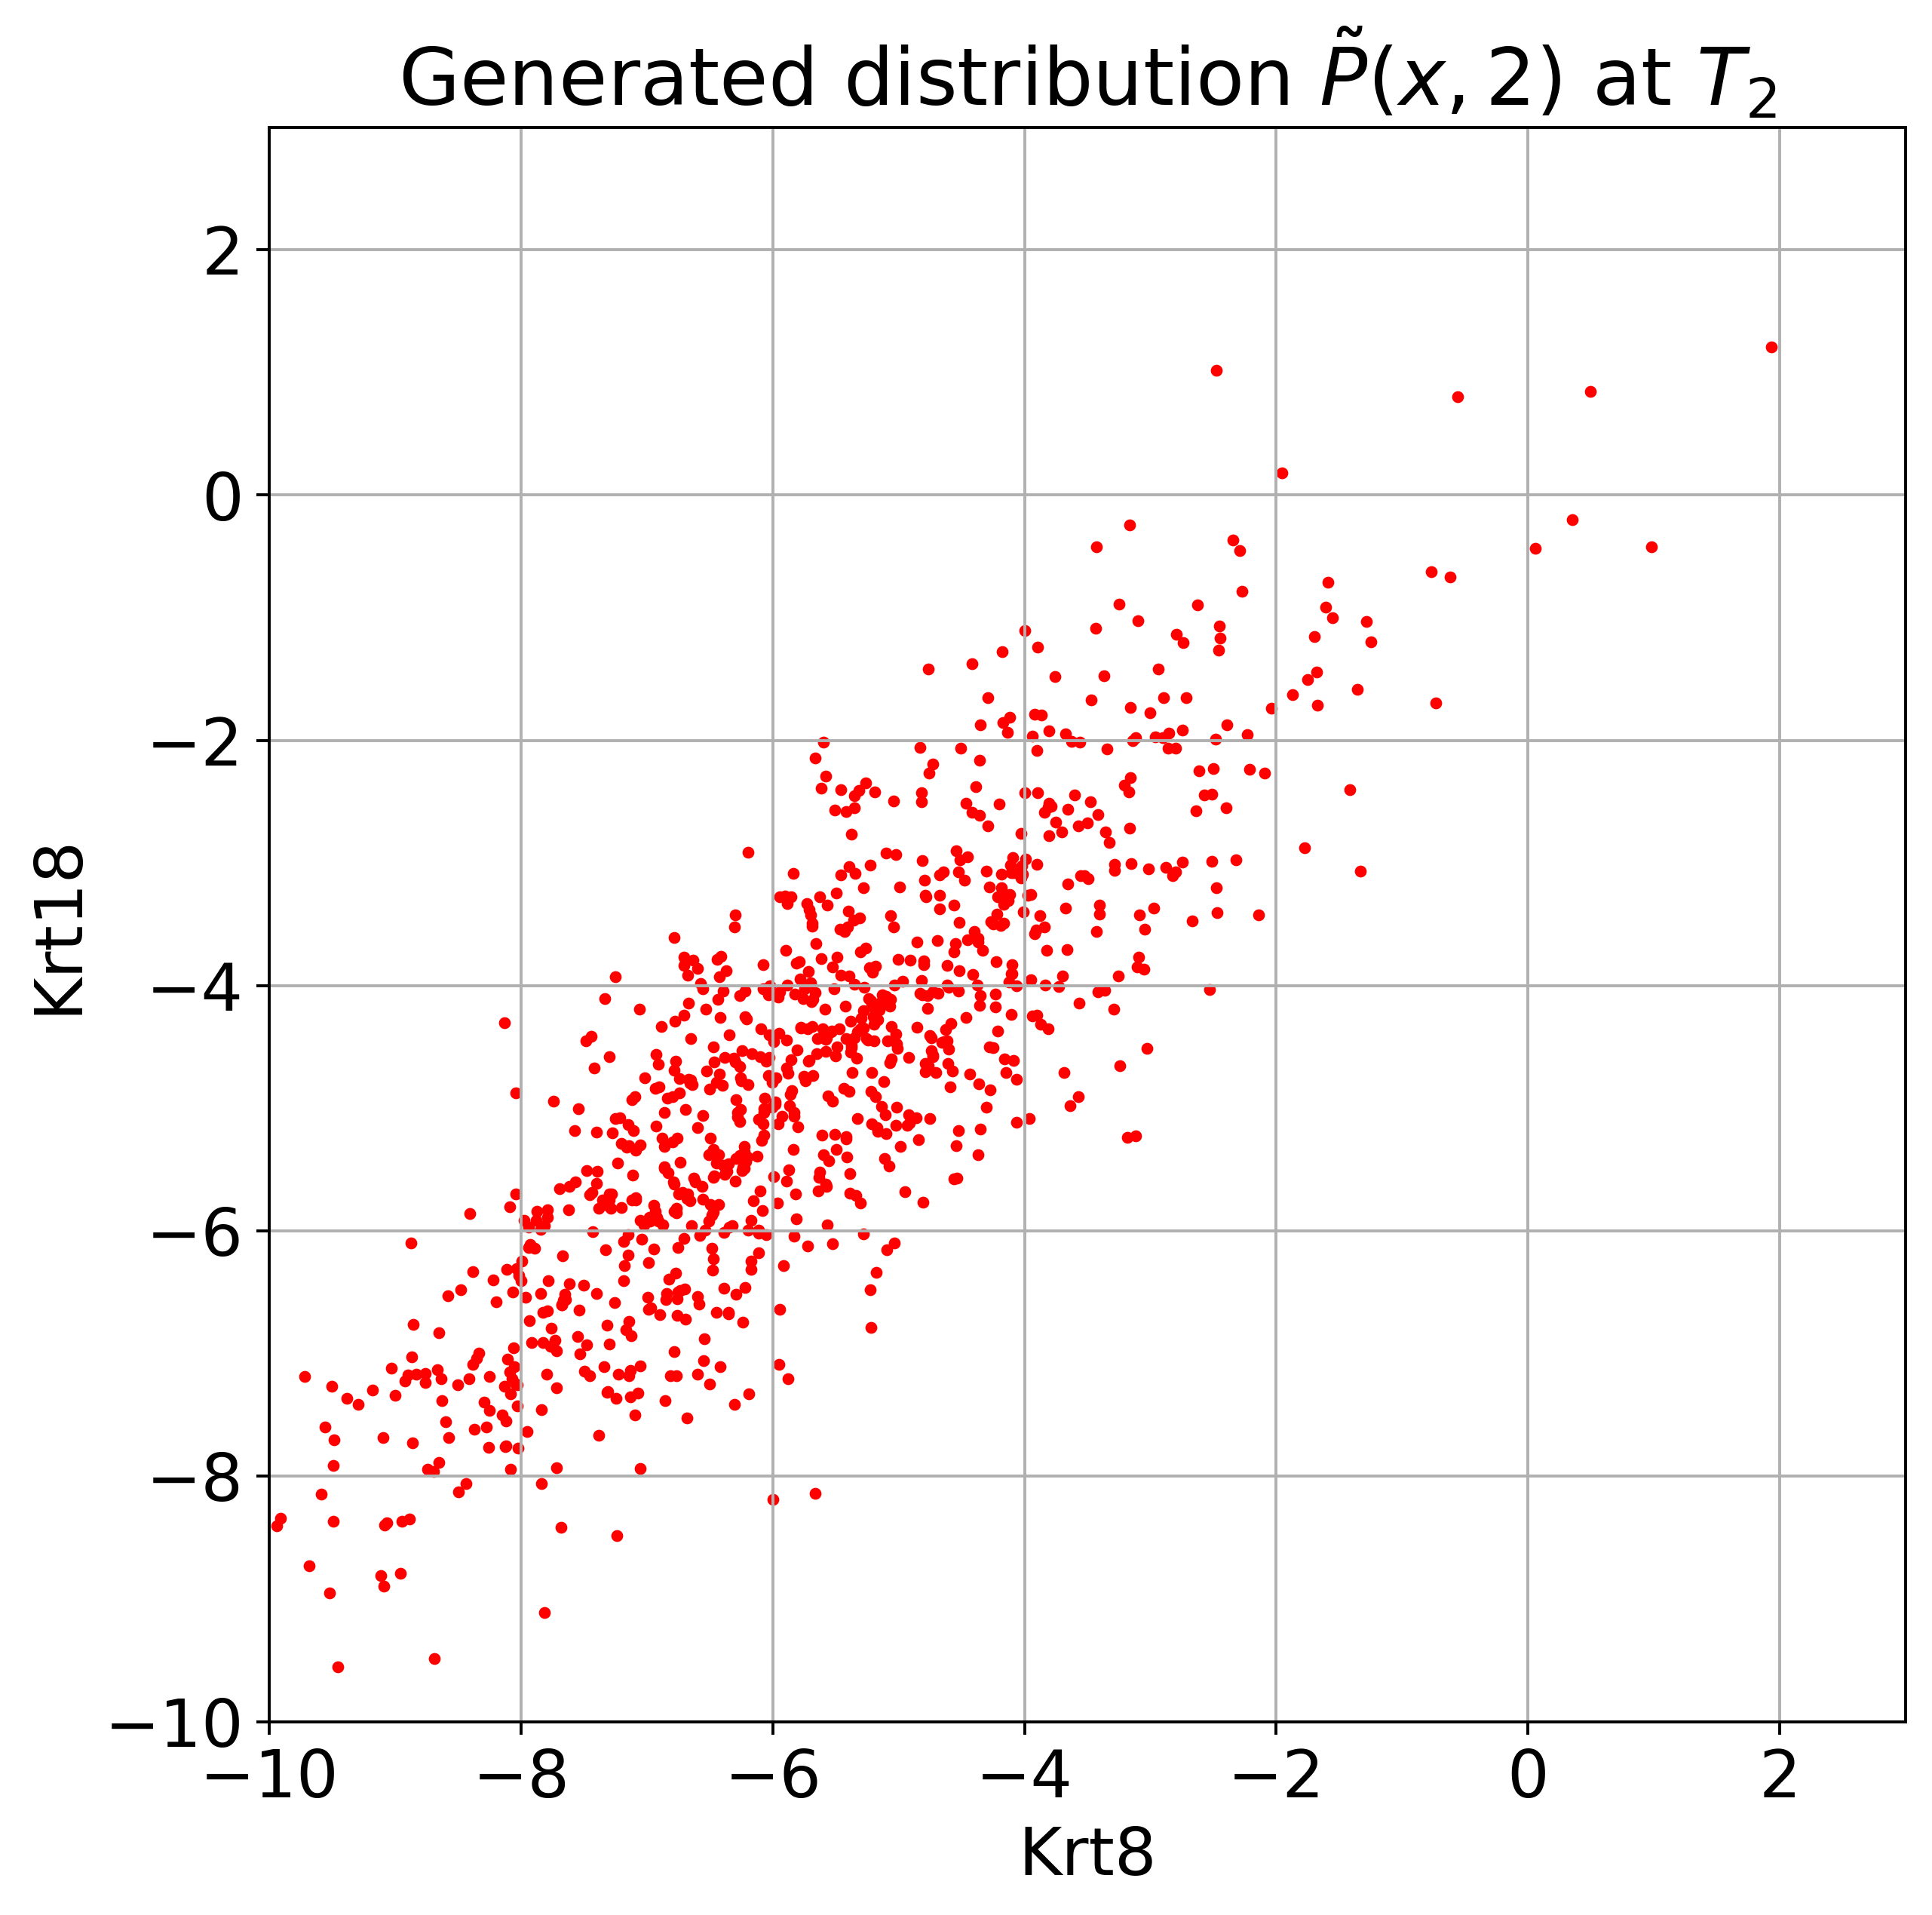

In [11]:
plt.figure(figsize=(8,8),dpi=350)
plt.xlim((-10,3))
plt.ylim((-10,3))
plt.title(r"Generated distribution $\tilde{P}(x,2)$ at $T_2$")
plt.scatter(G4[:,0],G4[:,1],s=5,color="red")
plt.xlabel("Krt8")
plt.ylabel("Krt18")
plt.grid()
plt.savefig('g2.eps',format='eps')